# Hyperparameter tuning with grid search

In [1]:
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import random

In [2]:
# Change file name (path) as necessary
# Read the data
df = pd.read_csv("../data/bachelor/df_training.csv", sep=',')

pd.set_option('display.max_columns', 47)
#df.head()

In [3]:
# Encode categorical features
df["study.level"] = df["study.level"].astype('category')
df["study.level"] = df["study.level"].cat.codes

df["curriculum.UUID"] = df["curriculum.UUID"].astype('category')
df["curriculum.UUID"] = df["curriculum.UUID"].cat.codes

df["faculty.code"] = df["faculty.code"].astype('category')
df["faculty.code"] = df["faculty.code"].cat.codes

df["prev.study.level"] = df["prev.study.level"].astype('category')
df["prev.study.level"] = df["prev.study.level"].cat.codes

df["workload"] = df["workload"].astype('category')
df["workload"] = df["workload"].cat.codes

In [4]:
# Drop person.UUID, study.place.UUID, debug.study.place.ID and debug.student.matricula.nr,
# because it's not reasonable to encode/use them.
df = df.drop(["person.UUID", "study.place.UUID", "debug.study.place.ID", "debug.student.matricula.nr"], axis=1)

In [5]:
# Ensure reproducibility
random.seed(10)

In [6]:
# Get X and y from data
X = df.drop('dropout', axis=1)
y = df['dropout']

# Separate 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
# Use SMOTE to oversample the training data
os = SMOTE(random_state=0)
X_train_os, y_train_os = os.fit_resample(X_train, y_train)

### 1. Random Forest

In [8]:
# Define the parameter grid for the Random Forest model
params = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, 15],
              'min_samples_split': [2, 5, 10]}

In [9]:
# Create a Random Forest model with default hyperparameters
rf = RandomForestClassifier(random_state=42)

In [10]:
# Perform hyperparameter tuning using GridSearchCV
scoring = ['roc_auc', 'f1']
grid_search_rf = GridSearchCV(rf, params, cv=10, scoring = scoring, refit='f1')
grid_search_rf.fit(X_train_os, y_train_os)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='f1', scoring=['roc_auc', 'f1'])

In [36]:
# Print the best hyperparameters and the mean cross-validation score
print(f'Best hyperparameters for Random Forest: {grid_search_rf.best_params_}')
print(f'Mean cross-validation score for Random Forest: {grid_search_rf.best_score_}')

Best hyperparameters for Random Forest: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 300}
Mean cross-validation score for Random Forest: 0.8956804910327933


In [12]:
# Save the best Random Forest model with the selected hyperparameters
best_rf = grid_search_rf.best_estimator_
joblib.dump(best_rf, '../models/best_rf_model.pkl')

['../models/best_rf_model.pkl']

### 2. XGBoost

In [42]:
# Define the parameter grid for the XGBoost model
params = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

In [43]:
# Create an XGBoost model with default hyperparameters
xgb_model = xgb.XGBClassifier(random_state=42)

In [44]:
# Perform hyperparameter tuning using GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=params, cv=10, n_jobs=-1, scoring = scoring, refit='f1')
grid_search_xgb.fit(X_train_os, y_train_os)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [45]:
# Print the best hyperparameters and the mean cross-validation score
print(f'Best hyperparameters for XGBoost: {grid_search_xgb.best_params_}')
print(f'Mean cross-validation score for XGBoost: {grid_search_xgb.best_score_}')

Best hyperparameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Mean cross-validation score for XGBoost: 0.89725460863109


In [46]:
# Save the best XGBoost model with the selected hyperparameters
best_xgb = grid_search_xgb.best_estimator_
joblib.dump(best_xgb, '../models/best_xgb_model.pkl')

['../models/best_xgb_model.pkl']

[18:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:33:08] WARNING: 

[18:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:33:08] WARNING: 

[18:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:33:08] WARNING: 

[18:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:32:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "C", "penalty", "solver" } are not used.

[18:33:08] WARNING: 

### 3. Logistic Regression

In [17]:
# Define the parameter grid for the Logistic Regression model
params = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

In [18]:
# Create a Logistic Regression model with default hyperparameters
logreg = LogisticRegression(random_state=42)

In [19]:
# Perform hyperparameter tuning using GridSearchCV
grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=params, cv=10, n_jobs=-1, scoring = scoring, refit='f1')
grid_search_logreg.fit(X_train_os, y_train_os)

/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206

/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Kertu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best hyperparameters for Logistic Regression: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
Mean cross-validation accuracy for Logistic Regression: 0.881852453679245


In [40]:
# Print the best hyperparameters and the mean cross-validation score
print(f'Best hyperparameters for Logistic Regression: {grid_search_logreg.best_params_}')
print(f'Mean cross-validation score for Logistic Regression: {grid_search_logreg.best_score_}')

Best hyperparameters for Logistic Regression: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
Mean cross-validation score for Logistic Regression: 0.881852453679245


In [20]:
# Save the best Logistic Regression model with the selected hyperparameters
best_logreg = grid_search_logreg.best_estimator_
joblib.dump(best_logreg, '../models/best_logreg_model.pkl')

['../models/best_logreg_model.pkl']

## Models testing on test set and reporting metrics

### Random Forest

In [21]:
# Generate predictions with rf model
rf_preds = best_rf.predict(X_test)
rf_proba = best_rf.predict_proba(X_test)[:, 1] 

In [22]:
# Have a look at predicted probabilities
rf_proba

array([3.01548488e-02, 8.33105824e-01, 9.48262935e-01, ...,
       9.88095606e-01, 8.43915756e-03, 2.19089355e-05])

In [23]:
# Get metrics
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_recall = recall_score(y_test, rf_preds)
rf_fscore = f1_score(y_test, rf_preds)

print("Random forest accuracy:", rf_accuracy)
print("Random forest precision:", rf_precision)
print("Random forest recall:", rf_recall)
print("Random forest F1-score:", rf_fscore)

# Metrics sanity check by hand
cm = confusion_matrix(y_test, rf_preds)
accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
print("Random forest accuracy by hand:", accuracy)

Random forest accuracy: 0.84858262272413
Random forest precision: 0.6836477987421383
Random forest recall: 0.8759065269943593
Random forest F1-score: 0.7679265277287177
Random forest accuracy by hand: 0.84858262272413


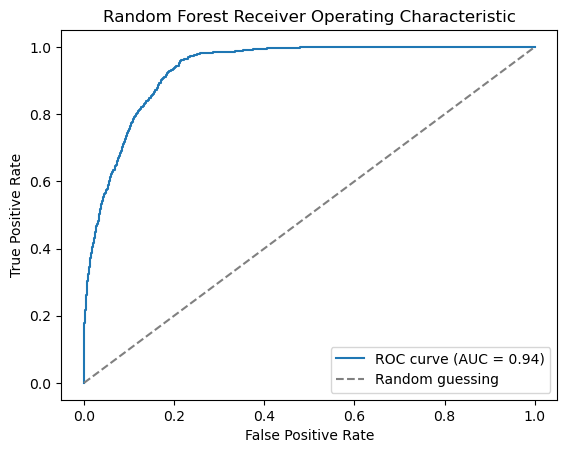

In [24]:
# Compute ROC curve and ROC-AUC score
fpr, tpr, thresholds = roc_curve(y_test.values, rf_proba) # y_test.values on array df asemel
roc_auc = roc_auc_score(y_test.values, rf_proba) # siin y_test.values on true labels, rf_proba ennustatud tõenäosused

## Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic')
plt.legend()
plt.show()

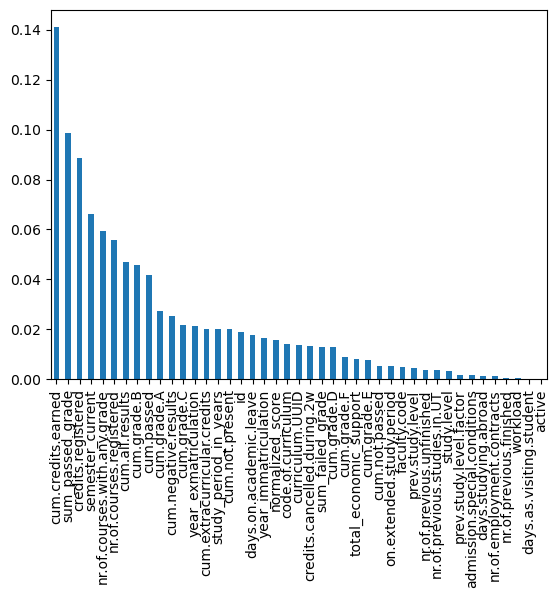

In [25]:
# Feature importances from the model (names are coming from the training data)
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train_os.columns).sort_values(ascending=False)

# Plot feature importance
feature_importances.plot.bar();

### XGBoost

In [26]:
 # Generate predictions with XGBoost model
xgb_preds = best_xgb.predict(X_test)
xgb_proba = best_xgb.predict_proba(X_test)[:, 1] 

In [27]:
# Have a look at predicted probabilities
xgb_proba

array([4.8213955e-03, 7.3632479e-01, 9.3637121e-01, ..., 9.8886186e-01,
       1.9973076e-03, 1.3227713e-04], dtype=float32)

In [28]:
# Get metrics
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_precision = precision_score(y_test, xgb_preds)
xgb_recall = recall_score(y_test, xgb_preds)
xgb_fscore = f1_score(y_test, xgb_preds)

print("XGBoost accuracy:", xgb_accuracy)
print("XGBoost precision:", xgb_precision)
print("XGBoost recall:", xgb_recall)
print("XGBoost F1-score:", xgb_fscore)

# Metrics sanity check by hand
cm_xgb = confusion_matrix(y_test, xgb_preds)
accuracy_xgb = (cm_xgb[0][0] + cm_xgb[1][1]) / cm_xgb.sum()
print("Random forest accuracy by hand:", accuracy_xgb)

XGBoost accuracy: 0.8642544365061074
XGBoost precision: 0.7462235649546828
XGBoost recall: 0.7961321514907332
XGBoost F1-score: 0.7703703703703704
Random forest accuracy by hand: 0.8642544365061074


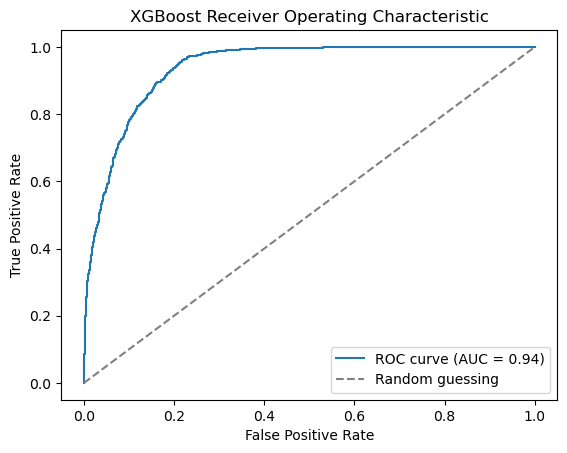

In [29]:
# Compute ROC curve and ROC-AUC score
fpr, tpr, thresholds = roc_curve(y_test.values, xgb_proba) # y_test.values on array df asemel
roc_auc_xgb = roc_auc_score(y_test.values, xgb_proba) # siin y_test.values on true labels, rf_proba ennustatud tõenäosused

## Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic')
plt.legend()
plt.show()

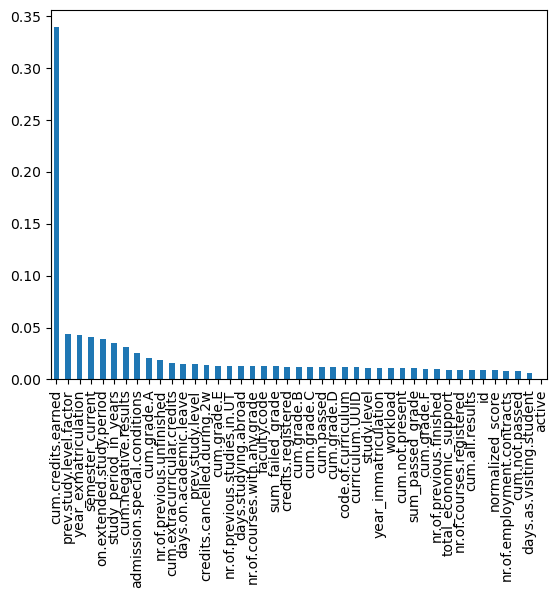

In [30]:
# Feature importances from the model (names are coming from the training data)
feature_importances = pd.Series(best_xgb.feature_importances_, index=X_train_os.columns).sort_values(ascending=False)

# Plot feature importance
feature_importances.plot.bar();

### Logistic regression

In [31]:
# Get predictions
logreg_preds = best_logreg.predict(X_test)
logreg_proba = best_logreg.predict_proba(X_test)[:, 1] 

In [32]:
logreg_proba

array([0.02392079, 0.57289138, 0.8961255 , ..., 0.82172595, 0.00839574,
       0.01101101])

In [33]:
# Get metrics
logreg_accuracy = accuracy_score(y_test, logreg_preds)
logreg_precision = precision_score(y_test, logreg_preds)
logreg_recall = recall_score(y_test, logreg_preds)
logreg_fscore = f1_score(y_test, logreg_preds)

print("Logistic regression  accuracy:", logreg_accuracy)
print("Logistic regression  precision:", logreg_precision)
print("Logistic regression  recall:", logreg_recall)
print("Logistic regression  F1-score:", logreg_fscore)

# Metrics sanity check by hand
cm_logreg = confusion_matrix(y_test, logreg_preds)
accuracy_logreg = (cm_logreg[0][0] + cm_logreg[1][1]) / cm_logreg.sum()
print("Logistic regression accuracy by hand:", accuracy_logreg)

Logistic regression  accuracy: 0.8418990550818161
Logistic regression  precision: 0.696113074204947
Logistic regression  recall: 0.7937147461724415
Logistic regression  F1-score: 0.7417168674698794
Logistic regression accuracy by hand: 0.8418990550818161


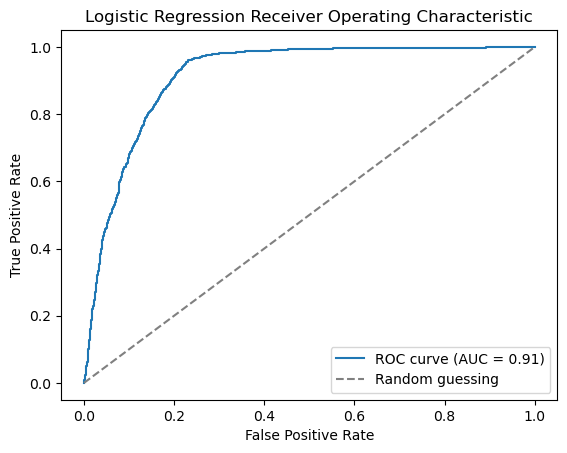

In [34]:
# Compute ROC curve and ROC-AUC score
fpr, tpr, thresholds = roc_curve(y_test, logreg_proba)
roc_auc_logreg = roc_auc_score(y_test, logreg_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_logreg)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic')
plt.legend()
plt.show()

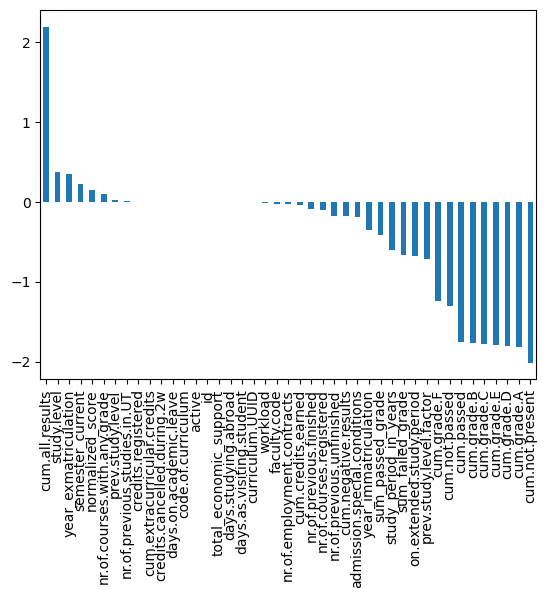

In [35]:
# Feature importances from the model (names are coming from the training data)
feature_importance_logreg = pd.Series(best_logreg.coef_[0], index=X_train_os.columns).sort_values(ascending=False)
# Plot feature importance
feature_importance_logreg.plot.bar();